In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# 1. Import the train datasets

In [2]:
X_train = pd.read_csv("data-train.csv",index_col=0)
Y_train = X_train.sales
X_train = X_train.drop(['sales'],axis=1)

In [3]:
#X_train = pd.read_csv("B_encoded_train_data.csv",index_col=0)
#Y_train = pd.read_csv("A_sales_train.csv",index_col=0)

In [4]:
Model_1 = DecisionTreeRegressor()

# 2. Setup Pipeline

In [5]:

RG = Model_1

In [6]:

pipe = Pipeline(steps=[("RG",RG)])

In [7]:
param_grid = {
    "RG__ccp_alpha":[0,0.001,0.005,0.1,0.5,2,8]
}

# 3. Setup GridSearch

In [8]:
score_metric = 'neg_mean_squared_error'
search = GridSearchCV(pipe,param_grid,
                      n_jobs=-1,
                      cv=10,
                      scoring=score_metric)

In [9]:
search.fit(X_train,Y_train.values.ravel())

GridSearchCV(cv=10, estimator=Pipeline(steps=[('RG', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'RG__ccp_alpha': [0, 0.001, 0.005, 0.1, 0.5, 2, 8]},
             scoring='neg_mean_squared_error')

In [10]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=-730.785):
{'RG__ccp_alpha': 0.005}


In [11]:
df = pd.DataFrame(search.cv_results_)
df = df.sort_values(by=['rank_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RG__ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2,0.063330,0.012936,0.003590,0.000798,0.005,{'RG__ccp_alpha': 0.005},-331.173706,-386.011649,-697.379734,-1008.893386,-2012.628411,-387.714429,-618.478541,-501.932453,-619.094219,-744.545830,-730.785236,468.560391,1
6,0.059242,0.010798,0.002593,0.000489,8,{'RG__ccp_alpha': 8},-333.755018,-354.666982,-877.548830,-1091.468585,-2297.209439,-191.099060,-730.823138,-589.390658,-603.697816,-670.838817,-774.049834,567.159138,2
1,0.061735,0.011065,0.004687,0.002363,0.001,{'RG__ccp_alpha': 0.001},-348.781219,-361.588393,-762.104403,-1047.163080,-2012.385331,-372.792833,-1903.697952,-525.144321,-623.098355,-854.514606,-881.127049,580.763102,3
5,0.058894,0.007695,0.003092,0.000537,2,{'RG__ccp_alpha': 2},-335.317754,-319.031803,-2238.490892,-1053.612171,-1968.069726,-337.426377,-612.631752,-604.690838,-834.890780,-1325.620816,-962.978291,651.484791,4
4,0.073910,0.021166,0.003392,0.000489,0.5,{'RG__ccp_alpha': 0.5},-669.958545,-309.245973,-2327.819793,-873.456592,-1947.417618,-354.167012,-857.062299,-543.846152,-750.366184,-1438.075533,-1007.141570,645.144343,5
3,0.076846,0.028037,0.004089,0.001133,0.1,{'RG__ccp_alpha': 0.1},-479.916727,-356.166732,-2337.698238,-1438.975332,-1967.735981,-384.582828,-1754.278061,-485.752499,-775.902744,-988.463691,-1096.947283,690.807196,6
0,0.053457,0.008055,0.004987,0.002044,0,{'RG__ccp_alpha': 0},-678.469828,-388.801724,-2221.689655,-1539.543103,-2061.463203,-391.294372,-1962.636364,-499.701299,-601.043290,-719.987013,-1106.462985,711.266592,7


# 4. Best Hyperparameter

In [12]:
parms = pd.DataFrame(df['params'])
for i in parms.iloc[0]:
    print(i)

{'RG__ccp_alpha': 0.005}


# 5. Evaluate Model $log(Sales)$

In [13]:
best_ccp_alpha = parms.iloc[0][0]['RG__ccp_alpha']

In [14]:
Model_2 = DecisionTreeRegressor(ccp_alpha=best_ccp_alpha)

In [15]:
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(X_train,Y_train,test_size=0.2,random_state=132)


In [16]:

RG1 = Model_2
RG1.fit(X_train1,Y_train1.values.ravel())

DecisionTreeRegressor(ccp_alpha=0.005)

In [17]:
MSE(RG1.predict(X_test1),Y_test1)

446.8042209202588

In [18]:
result = pd.DataFrame(Y_test1)

In [19]:
result["Predicted_sales"] = RG1.predict(X_test1)

In [20]:
MSE(result["sales"],result["Predicted_sales"])

446.8042209202588

# 6. Inventory Decision

In [21]:
residual = result['sales']-result['Predicted_sales']

In [22]:
Price=20
Cost=12
Salvage=8
Over=Cost - Salvage
Under=Price - Cost
Over, Under

(4, 8)

### QQ plot to explore the distribution of residual

#### Normal Distribution

In [23]:
import scipy.stats as sct

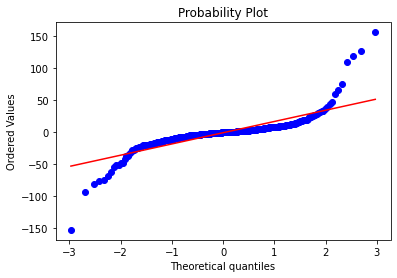

In [24]:
import scipy
scipy.stats.probplot(residual, dist="norm", plot=plt)
plt.show()

In [25]:
s = residual.std()
opt_dec_N=round(sct.norm.ppf(Under/(Under+Over))*s + result['Predicted_sales'])

#### Exponential Distribution

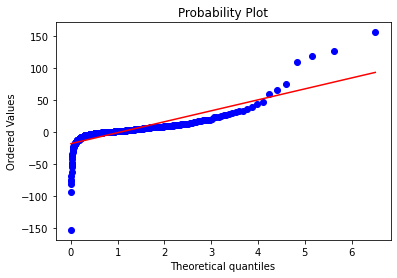

In [26]:
scipy.stats.probplot(residual, dist="expon", plot=plt)
plt.show()

In [27]:
opt_dec_E=round((-result['Predicted_sales'])*np.log(1-(Under/(Under+Over))))

#### Empirical Distribution

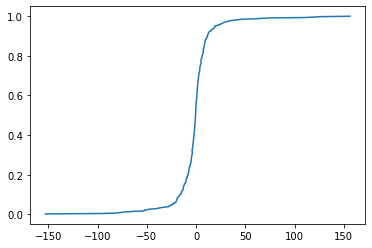

In [28]:
size = residual.shape[0]
step=1/size
jumps = [step*i for i in range(1,size+1)]
Sample = sorted(residual)
plt.plot(Sample,jumps)

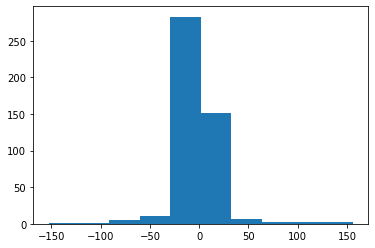

In [29]:
plt.hist(Sample)
plt.show()

In [30]:
def inv(sample,jump,area):
    size = len(sample)
    i=0
    temp=jump[i]
    while temp<area:
        i+=1
        temp=jump[i]
        
    return sample[i]

In [31]:
offset = inv(Sample,jumps,2/3)
offset

1.75

In [32]:
opt_dec_B = round(result['Predicted_sales']+offset)

# 7. Out-of-samples Profit

In [33]:
#max profit for test data set
max_profit = result['sales'].sum()*(Price-Cost)
max_profit

82096

In [34]:
def profit(demand,inv):
    return (Price-Salvage)*np.minimum(demand,inv)-(Cost-Salvage)*inv

In [35]:
#Profit (Normal)
profit_lst_N = profit(result['sales'],opt_dec_N)
profit_lst_N.sum()

49592.0

In [36]:
#Profit (Exponential)
profit_lst_E = profit(result['sales'],opt_dec_E)
profit_lst_E.sum()

53256.0

In [37]:
#Profit (Empirical)
profit_lst_B = profit(result['sales'],opt_dec_B)
profit_lst_B.sum()

54084.0

# 8. K-Fold Cross Validation

### Repeat steps 5,6,7 with 10-fold cross validation

In [38]:
Model_4= DecisionTreeRegressor(ccp_alpha=best_ccp_alpha)

In [39]:
from sklearn.model_selection import KFold
k=10
kf = KFold(n_splits=k)
X_train_t=X_train.to_numpy()
Y_train_t=Y_train.to_numpy()
model = []
mse_lst = []
max_profit_lst = []
profit_N_lst = []
profit_E_lst = []
profit_B_lst = []

for train_index,test_index in kf.split(X_train_t):
    X_train_K,X_test_K=X_train_t[train_index],X_train_t[test_index]
    Y_train_K,Y_test_K=Y_train_t[train_index],Y_train_t[test_index]
    
    #PCA to transform train data
    
    #Model
    RG_K = Model_4
    RG_K.fit(X_train_K,Y_train_K.ravel())
    
    #pca to transform test data
    
    #MSE
    mse_lst.append(MSE(RG_K.predict(X_test_K),Y_test_K))
    
    #Transform log(sale) back to sale
    result_K = pd.DataFrame(Y_test_K)
    result_K["Predicted_sales"] = RG_K.predict(X_test_K)
    
    #Obtain residual
    residual_K = result_K[0]-result_K['Predicted_sales']
    
    #Get std for Normal distribution
    s_K = residual.std()
    
    #Inventory Decision (Normal)
    opt_dec_N_K=np.ceil(sct.norm.ppf(Under/(Under+Over))*s_K + result_K['Predicted_sales'])
    #Inventory Decision (Exponential)
    opt_dec_E_K=np.ceil((-result_K['Predicted_sales'])*np.log(1-(Under/(Under+Over))))
    
    #Inventory Decision (Empirical Distribution)
    size_K = residual_K.shape[0]
    step_K=1/size_K
    jumps_K = [step_K*i for i in range(1,size+1)]
    Sample_K = sorted(residual_K)
    offset_K = inv(Sample_K,jumps_K,2/3)
    opt_dec_B_K = np.ceil(result_K['Predicted_sales']+offset_K)
    
    #Out-of_sample profit
    profit_lst_B_K = profit(result_K[0],opt_dec_B_K)
    profit_B_lst.append(profit_lst_B_K.sum())
    
    profit_lst_N_K = profit(result_K[0],opt_dec_N_K)
    profit_N_lst.append(profit_lst_N_K.sum())
    
    profit_lst_E_K = profit(result_K[0],opt_dec_E_K)
    profit_E_lst.append(profit_lst_E_K.sum())
    
    max_profit_K = result_K[0].sum()*(Price-Cost)
    max_profit_lst.append(max_profit_K)
    
max_profit_lst = np.array(max_profit_lst)
profit_N_lst = np.array(profit_N_lst)
profit_E_lst = np.array(profit_E_lst)
profit_B_lst = np.array(profit_B_lst)

fraction_of_max_N = profit_N_lst/max_profit_lst
fraction_of_max_E = profit_E_lst/max_profit_lst
fraction_of_max_B = profit_B_lst/max_profit_lst

dist_profit = ["Normal","Exponential","Empirical","Max"]
dist_frac = ["Normal","Exponential","Empirical"]
col_name = ["Dataset_"+str(i) for i in range(1,k+1)]

profit_lst = [profit_N_lst,profit_E_lst,profit_B_lst,max_profit_lst]
profit_table = pd.DataFrame(profit_lst,index=dist_profit,columns=col_name)
profit_table["mean_profit"]=profit_table.mean(axis=1)
profit_table["std_profit"]=profit_table.std(ddof=1,axis=1)

fraction_lst = [fraction_of_max_N,fraction_of_max_E,fraction_of_max_B]
fraction_table = pd.DataFrame(fraction_lst,index=dist_frac,columns=col_name)
fraction_table["mean_fraction"]=fraction_table.mean(axis=1)

In [40]:
fraction_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5,Dataset_6,Dataset_7,Dataset_8,Dataset_9,Dataset_10,mean_fraction
Normal,0.606708,0.632226,0.575600,0.610129,0.591056,0.574268,0.645646,0.584996,0.608626,0.530061,0.595931
Exponential,0.683646,0.662896,0.627959,0.640258,0.637067,0.636038,0.681261,0.616219,0.670902,0.586919,0.644316
Empirical,0.699207,0.662719,0.635649,0.651588,0.636825,0.650072,0.675462,0.628708,0.674123,0.593834,0.650819


In [41]:
profit_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5,Dataset_6,Dataset_7,Dataset_8,Dataset_9,Dataset_10,mean_profit,std_profit
Normal,25108.0,28612.0,26648.0,28432.0,29340.0,22424.0,31616.0,26980.0,27208.0,22076.0,26844.4,2830.598778
Exponential,28292.0,30000.0,29072.0,29836.0,31624.0,24836.0,33360.0,28420.0,29992.0,24444.0,28987.6,2598.370228
Empirical,28936.0,29992.0,29428.0,30364.0,31612.0,25384.0,33076.0,28996.0,30136.0,24732.0,29265.6,2415.460999
Max,41384.0,45256.0,46296.0,46600.0,49640.0,39048.0,48968.0,46120.0,44704.0,41648.0,44966.4,3203.875254


In [42]:
profit_table.to_csv(".\\Model_Selection_Result\\4.2B_Decision_tree(No_PCA).csv")

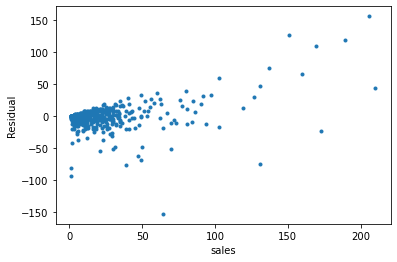

In [43]:
plt.xlabel("sales")
plt.ylabel("Residual")
plt.plot(result['sales'],residual,".")